In [1]:
%load_ext lab_black

In [2]:
from pathlib import Path
from typing import Union, Dict, Optional, List
from collections import defaultdict
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker

from camelsml.metrics import calc_nse
from camelsml.datautils import load_attributes
from camelsml import load_config
from camelsml.utils import get_basin_list
import scipy.cluster as spc

# This notebook contains results from our attempt at reducing static features.

In [3]:
def correlation(
    attributes: pd.DataFrame, title: Optional[str] = None, ax: Optional[plt.Axes] = None
):
    corr = attributes.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    if ax is None:
        fig, ax = plt.subplots(figsize=(4.7747, 4.7747))
    ax.tick_params(axis="both", which="both", labelsize=5)
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(
        corr,
        mask=mask,
        cmap=cmap,
        center=0,
        square=True,
        linewidths=0.1,
        cbar_kws={"shrink": 0.5},
        ax=ax,
    )
    ax.xaxis.label.set_size(5)
    ax.yaxis.label.set_size(0)
    if title is not None:
        ax.set_title(title)

In [4]:
def dendrogram(
    attributes: pd.DataFrame,
    ax: Optional[plt.Axes] = None,
) -> np.ndarray:
    # Using the absolute value Pearson correlations.
    corr = attributes.corr().abs()
    corr_linkage = spc.hierarchy.ward(corr)
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    dendro = spc.hierarchy.dendrogram(
        corr_linkage, ax=ax, orientation="left", labels=attributes.columns
    )
    return corr_linkage


def feature_reduction(
    corr_linkage: np.ndarray, level: int, labels: np.ndarray
) -> np.ndarray:
    cluster_ids = spc.hierarchy.fcluster(corr_linkage, level, criterion="distance")
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
    return labels[selected_features]

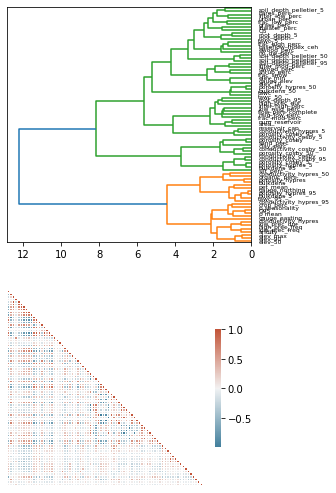

In [5]:
cfg = load_config("../runs/correlation_reduction/all_features/run_config.txt")
db_path = "../runs/correlation_reduction/all_features/run_1412_0900_seed19970204/attributes.db"
basins = get_basin_list(cfg["train_basin_file"])
attributes = load_attributes(
    db_path=db_path,
    basins=basins,
)
fig, axes = plt.subplots(2, 1, figsize=(4.7747, 4.47747 * 1.618))  # 8.27615))
axes = axes.flatten()
correlation(attributes, ax=axes[1])
axes[1].set_xticks([])
axes[1].set_yticks([])
corr_linkage = dendrogram(attributes, ax=axes[0])
# axes[0].set_yticks([])
# axes[0].set_xticks([])
fig.tight_layout()
fig.savefig(
    "../doc/thesis/figures/correlation_reduction/all_features/corr_and_dendrogram.pdf"
)

In [6]:
def load_results(folder: Union[Path, str], model_type: str, seed: int) -> Dict:
    if isinstance(folder, str):
        folder = Path(folder)
    if not folder.exists():
        raise FileNotFoundError(f"No directory found at {folder}")
    nse_values = defaultdict(dict)
    epochs = len(list(folder.rglob(f"{model_type}_seed{seed}_epoch_*.p")))
    if epochs == 0:
        raise FileNotFoundError(f"No validation runs found")
    for epoch in range(1, epochs + 1):
        file = folder / f"{model_type}_seed{seed}_epoch_{epoch}.p"
        with open(file, "rb") as results_file:
            results = pickle.load(results_file)
        for basin in results.keys():
            nse_values[f"epoch_{epoch}"][basin] = calc_nse(
                obs=results[basin]["qobs"].to_numpy(),
                sim=results[basin]["qsim"].to_numpy(),
            )
    return nse_values

In [7]:
def restructure_results(nse_values: Dict) -> np.ndarray:
    results = []
    for i, epoch in enumerate(nse_values.keys()):
        results.append(np.array(list(nse_values[epoch].values())))
    results = np.array(results).T
    return results


def nse_boxplots(
    nse_values: np.ndarray, title: Optional[str] = None, ax: Optional[plt.Axes] = None
):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=[10, 10])
    ax.boxplot(nse_values, showmeans=True)
    # ax.set_xlabel("Epoch")
    # ax.set_ylabel("NSE")
    ax.grid()
    epochs = nse_values.shape[1] + 1
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    if title is not None:
        ax.set_title(title)


def plot_median_average(
    nse_values: np.ndarray, title: Optional[str] = None, ax: Optional[plt.Axes] = None
):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=[10, 10])
    epochs = range(1, nse_values.shape[1] + 1)
    ax.plot(epochs, nse_values.mean(axis=0), label="mean")
    ax.plot(epochs, np.median(nse_values, axis=0), label="median")
    ax.set_ylim([0, 1])
    # ax.set_xlabel("Epoch")
    # ax.set_ylabel("NSE")
    ax.grid()
    ax.legend()
    if title is not None:
        ax.set_title(title)


def plot_fractions(
    nse_values: np.ndarray,
    good_model: float = 0.7,
    title: Optional[str] = None,
    ax: Optional[plt.Axes] = None,
):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=[10, 10])
    epochs = range(1, nse_values.shape[1] + 1)
    basins = nse_values.shape[0]
    frac = []
    for i, epoch in enumerate(nse_values.T):
        frac.append(len(epoch[epoch > good_model]))
        frac[i] /= basins
    ax.plot(epochs, frac)
    # ax.set_xlabel("Epoch")
    # ax.set_ylabel(rf"$\frac{{nse>{good_model}}}{{nse}}$")
    ax.grid()
    if title is not None:
        ax.set_title(title)

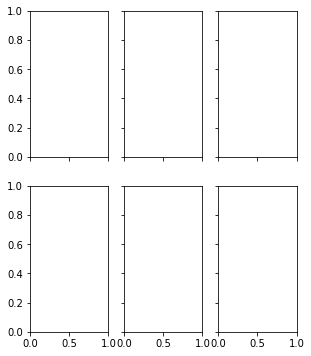

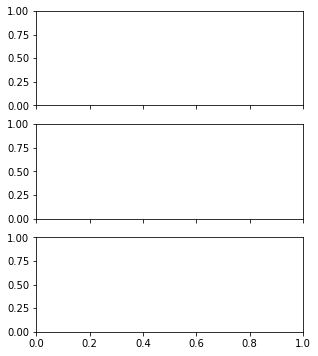

In [8]:
fig_runs_plots, axes_runs_plots = plt.subplots(
    2, 3, figsize=[4.7747, (4.7747 / 1.618) * 2], sharey=True, sharex=True
)
fig_runs_boxplots, axes_runs_boxplots = plt.subplots(
    3, 1, figsize=[4.7747, (4.7747 / 1.618) * 2], sharex=True, sharey=True
)

In [9]:
good_model = 0.7
results_full_features = load_results(
    "../runs/correlation_reduction/all_features/run_1412_0900_seed19970204",
    "ealstm",
    19970204,
)
nse_values_full = restructure_results(results_full_features)
title_full = "76 features"
nse_boxplots(
    nse_values_full,
    ax=axes_runs_boxplots[0],
    title=title_full,
)
plot_median_average(nse_values_full, ax=axes_runs_plots[0, 0], title=title_full)
plot_fractions(nse_values_full, good_model=good_model, ax=axes_runs_plots[1, 0])

## Removing 20 features by setting the treshold to 9.3

This will be used to train a new model

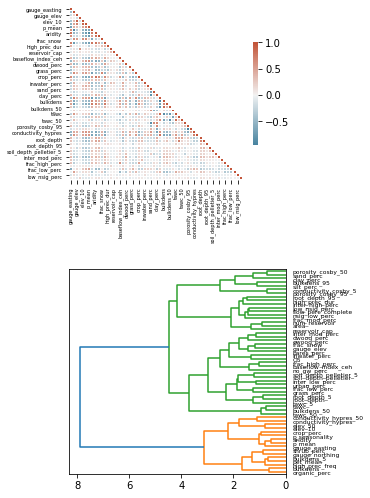

In [10]:
keep = feature_reduction(corr_linkage, level=0.93, labels=attributes.columns.to_numpy())
np.savetxt(
    "../runs/correlation_reduction/20_less_features/use_features.txt", keep, fmt="%s"
)
fig_corr_56, axes_corr_56 = plt.subplots(2, 1, figsize=(4.7747, 4.47747 * 1.618))
axes = axes_corr_56.flatten()
reduced_attributes_20 = load_attributes(db_path, basins=basins, keep_features=keep)
correlation(reduced_attributes_20, ax=axes_corr_56[0])
corr_linkage_20_less = dendrogram(reduced_attributes_20, ax=axes_corr_56[1])
fig_corr_56.tight_layout()

In [11]:
results_56_features = load_results(
    "../runs/correlation_reduction/20_less_features/run_1512_0054_seed19970204",
    "ealstm",
    19970204,
)
title_56_features = "56 features"
nse_values_56_features = restructure_results(results_56_features)
nse_boxplots(nse_values_56_features, ax=axes_runs_boxplots[1], title=title_56_features)
plot_median_average(
    nse_values_56_features, title=title_56_features, ax=axes_runs_plots[0, 1]
)
plot_fractions(nse_values_56_features, ax=axes_runs_plots[1, 1])

(434, 36)


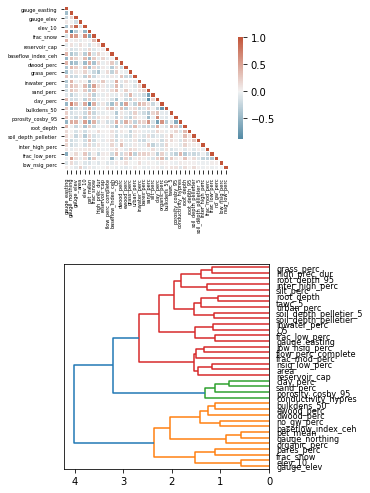

In [12]:
keep = feature_reduction(
    corr_linkage_20_less, level=1.15, labels=reduced_attributes_20.columns.to_numpy()
)
np.savetxt(
    "../runs/correlation_reduction/40_less_features/use_features.txt", keep, fmt="%s"
)
fig, axes = plt.subplots(2, 1, figsize=(4.7747, 4.47747 * 1.618))
axes = axes.flatten()
reduced_attributes_40 = load_attributes(db_path, basins=basins, keep_features=keep)
correlation(reduced_attributes_40, ax=axes[0])
corr_linkage_40_less = dendrogram(reduced_attributes_40, ax=axes[1])
fig.tight_layout()
print(reduced_attributes_40.shape)

In [13]:
results_36_features = load_results(
    "../runs/correlation_reduction/40_less_features/run_1512_1507_seed19970204",
    "ealstm",
    19970204,
)
title_36_features = "36 features"
nse_values_36_features = restructure_results(results_36_features)
nse_boxplots(nse_values_36_features, ax=axes_runs_boxplots[2], title=title_36_features)
plot_median_average(
    nse_values_56_features, title=title_36_features, ax=axes_runs_plots[0, 2]
)
plot_fractions(nse_values_36_features, ax=axes_runs_plots[1, 2])
axes_runs_plots[0, 0].set_ylabel("NSE")
axes_runs_plots[1, 0].set_ylabel(rf"$\frac{{nse>{good_model}}}{{nse}}$")
axes_runs_plots[1, 1].set_xlabel("Epochs")
fig_runs_plots.tight_layout()
axes_runs_boxplots[0].set_ylim([0, 1])
fig_runs_boxplots.tight_layout()
fig_runs_boxplots.savefig("boxplots.pdf")
fig_runs_plots.savefig("plots.pdf")

## No features

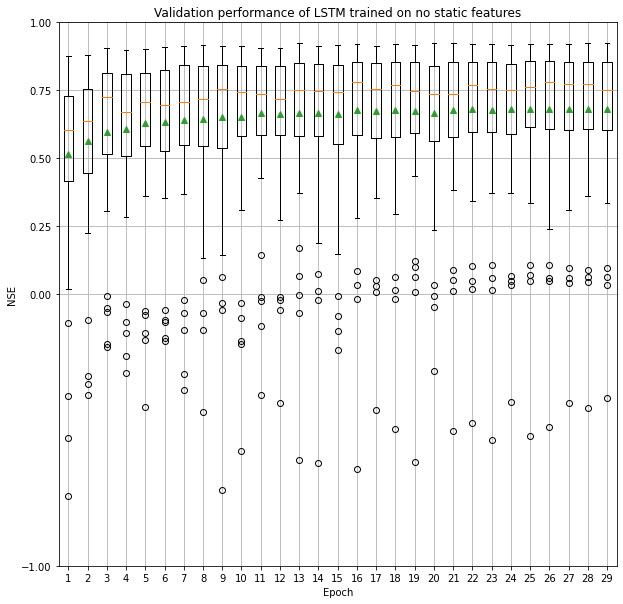

[0.5150712  0.56446055 0.59572951 0.60693396 0.62737508 0.63172847
 0.64141031 0.64488117 0.65077532 0.65117622 0.66422243 0.66377579
 0.66679024 0.66768827 0.66262918 0.67663089 0.67491199 0.67578069
 0.67345956 0.66645644 0.67844584 0.6810841  0.67740282 0.67994772
 0.68094386 0.68047077 0.68113151 0.6806065  0.68042789]
[0.31613754 0.27657207 0.36898281 0.27822    0.27603692 0.26489758
 0.27750553 0.2637253  0.27991733 0.28980646 0.25230154 0.24904262
 0.26608791 0.2599715  0.24933227 0.2601183  0.24243754 0.25367022
 0.25931523 0.24309106 0.24712379 0.24631469 0.25049229 0.23801029
 0.2476511  0.24928664 0.24180596 0.24012956 0.23797215]
[0.60407503 0.63502903 0.72453008 0.67058633 0.70492761 0.69653176
 0.70683478 0.71782549 0.75457762 0.74438511 0.73730187 0.71691596
 0.74921384 0.74606278 0.74162895 0.77845296 0.75287263 0.76879144
 0.74738033 0.7374584  0.73400713 0.76925015 0.75311397 0.75029444
 0.76329497 0.78113649 0.77383701 0.77088363 0.74897094]


In [15]:
results_no_features = load_results(
    "../runs/correlation_reduction/no_features/run_1612_0909_seed19970204",
    "lstm_no_static",
    19970204,
)
results = []
for i, epoch in enumerate(results_no_features.keys()):
    results.append(np.array(list(results_no_features[epoch].values())))
results = np.array(results).T
fig, ax = plt.subplots(1, 1, figsize=[10, 10])
ax.boxplot(results, showmeans=True)
ax.set_xlabel("Epoch")
ax.set_ylabel("NSE")
ax.grid()
ax.set_yticks([-1, 0, 0.25, 0.5, 0.75, 1])
ax.set_ylim([-1, 1])
ax.set_title("Validation performance of LSTM trained on no static features")
plt.show()
print(results.mean(axis=0))
print(results.std(axis=0))
print(np.median(results, axis=0))

Forcing -> Physical model  (EXISTS FOR US)  -> Prediction 

                                                            -> Improved prediction 
                                                            
Forcing + static features -> Lstm model     -> Prediction 